## Прогноз заказов сервиса такси

#### **Постановка задачи**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо создать модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

**Инструкция по выполнению проекта**

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

## Подготовка данных

### Загрузка данных и библиотек

In [7]:
# python libraries
import numpy as np
import pandas as pd

# import warnings library
import warnings     

# stats libraries
from statsmodels.tsa.seasonal import seasonal_decompose

# ML libraries
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
 

In [8]:
plt.style.use('ggplot')
warnings.filterwarnings("ignore") # if there is a warning after some codes, this will avoid us to see them.
SEED = 777

In [9]:
# загружаем данные
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except FileNotFoundError:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [10]:
df.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


<AxesSubplot:xlabel='datetime'>

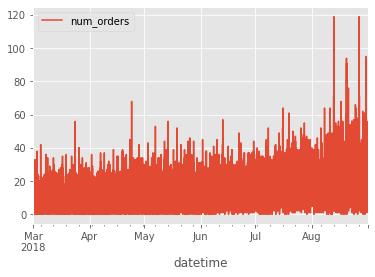

In [12]:
df.plot()

In [13]:
# проверяем индекс на целостность
df.index.is_monotonic

True

В представленном датасете свыше 26 тыс. записей временного ряда с десятиминутным интервалом количества заказов (num_orders) службы такси за 5 месяцев 2018 года. Данный признак является также целевым для прогнозирования. Индекс проверен на целостность.

## Анализ данных

Изучим данные в различных разрезах.

<AxesSubplot:title={'center':'Заказы понедельно'}, xlabel='datetime'>

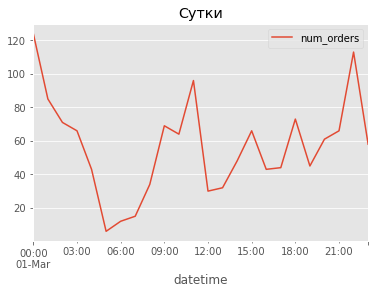

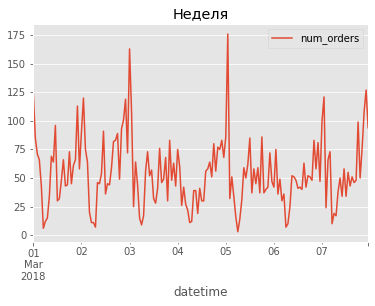

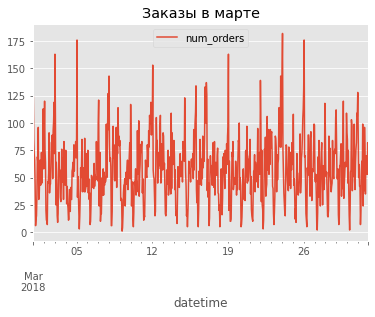

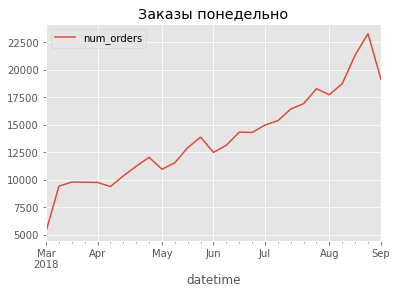

In [14]:
# приведем данные к одному часу
data = df.resample('1H').sum()

# часовой график
data.head(24).plot(title='Сутки')

# недельный график
data.loc['2018-03-01':'2018-03-07'].plot(title='Неделя')

# график по марту
data.loc['2018-03'].plot(title='Заказы в марте')

# график понедельно
df.resample('1W').sum().plot(title='Заказы понедельно')


Проверим какая наблюдается сезонность в заказах такси на дневных данных.

<AxesSubplot:title={'center':'Residuals'}, xlabel='datetime'>

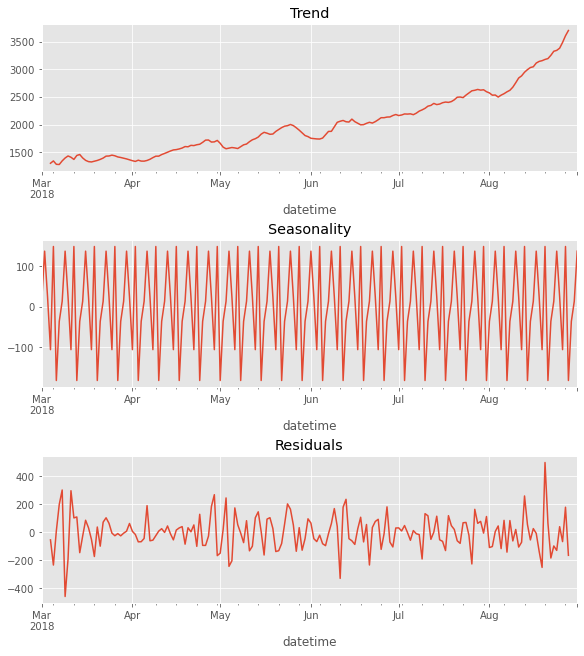

In [15]:
# декомпозиция временного ряда
decomposed = seasonal_decompose(df.resample('1D').sum())

#размеры графиков
plt.figure(figsize=(8, 9), constrained_layout=True)

#график тренда
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), title='Trend')

#график сезонности
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), title='Seasonality')

#график "остатков"
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), title='Residuals')


Посмотрим также распределение заказов по дням недели.

<AxesSubplot:xlabel='wd', ylabel='num_orders'>

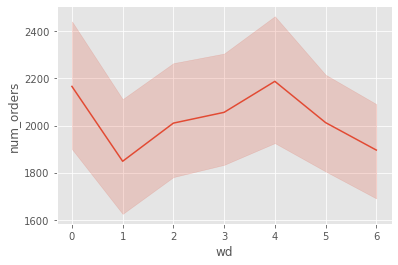

In [16]:
data_wd = df.resample('1D').sum()
data_wd = data_wd.assign(wd = data_wd.index.weekday)

# data_wd.groupby(by=['num_week', 'wd']).mean().head(15).plot()

# заказы по дням недели
sns.lineplot(data=data_wd, x='wd', y='num_orders')

In [17]:
monthly_orders = data.groupby(by=[data.index.month])['num_orders'].agg(['min', 'max', 'mean', 'std'])
monthly_orders['mean_temp'] = (monthly_orders['mean'] / monthly_orders['mean'].shift())
print('Метрики заказов по месяцам')
monthly_orders

Метрики заказов по месяцам


,min,max,mean,std,mean_temp
datetime,,,,,
3,1,182,57.483871,29.562439,NaN
4,0,253,63.804167,32.036301,1.109949
5,2,234,73.682796,34.849825,1.154827
6,6,229,83.202778,32.826776,1.129202
7,11,251,100.006720,37.254770,1.201964
8,13,462,127.651882,56.242228,1.276433


#### **Выводы:**

1. Временной ряд нестационарный - его статистики меняются со временем.
2. В целом такси пользуется успехом - за полгода объем заказов вырос больше чем в 2 раз.
3. Наблюдаются дневные пики спроса в районе полуночи и спады ранним утром.
4. Наблюдается также цикличность заказов по дням недели - больше всего заказов в понедельник и пятницу.

## Обучение моделей

Для прогнозирования значений временного ряда 

1. Сконструируем дополнительные признаки на базе имеющихся данных
2. Подготовим функции для обучения моделей с разными параметрами на кросс-валидации
3. Проведем обучение и вычислим метрики следующих моделей: Linear Regression, Lasso, LightGBM, Random Forest и CatBoost.

### Конструирование признаков

Создадим дополнительные признаки, которые позволят моделям находить закономерности в данных. Добавим в обучающие данные информацию о номерах месяцев и дней недели, разности временного ряда, отстающие значения и скользящие средние с разными окнами. Работать будем с часовыми данными, т.к. задача состоит в выдаче прогноза на следующий час.

Определим несколько функций.

In [18]:
def split_data(df, target=None, drop_target=False):
    # Функция разделяет датасет на обучающую и тестовую выборки 
    y = df.copy()
    X = df.copy()
    if drop_target:
        y = y[target]
        X = X.drop(target, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, 
                                                        test_size=0.1, random_state=SEED)
    print('Выборки для моделирования:')
    print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
    print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')
    return X_train, X_test, y_train, y_test


In [19]:
class TaxiFeatComposer(BaseEstimator, TransformerMixin):
    '''
    Класс определяет функции для конструирования признаков
    '''
    def __init__(self, target, max_lag, rolling_mean_size, fillna=True, drop_target=True):
        self.target = target
        self.max_lag = max_lag
        self.rolling_mean_size = rolling_mean_size
        self.fillna = fillna
        self.drop_target = drop_target
        
    def _reset(self):        
        if hasattr(self, 'X_'):
            del self.X_
            del self.y_
        
    def fit(self, X, y=None):
        # self._reset()           
        self.X_ = X.drop(columns=self.target)
        self.y_ = X[self.target]
        return self
        
    def transform(self, X):
        X_new = X.copy()
        # компоненты даты и времени
        X_new['month'] = X.index.month.astype('int')    
        X_new['day'] = X.index.day.astype('int')
        X_new['dayofweek'] = X.index.dayofweek.astype('int')
        X_new['hour'] = X.index.hour
        # отстающие значения
        for lag in range(1, self.max_lag +1):
            X_new[f'lag_{lag}'] = X_new[self.target].shift(lag)
        # скользящее среднее
        X_new['rolling_mean'] = X_new[self.target].shift().rolling(self.rolling_mean_size).mean()
        if self.drop_target:
            X_new = X_new.drop(columns=self.target, axis=1)
        # заполнение пропусков первым доступным значением
        if self.fillna:
            X_new = X_new.fillna(method='bfill')
    
        return X_new

Разделим данные на тренировочную и тестовую выборки и протестируем работу класса.

In [20]:
# проверка
X_train, X_test, y_train, y_test = split_data(data)
taxi = TaxiFeatComposer('num_orders', 5, 7)
taxi_x = taxi.fit_transform(X_train)
taxi_x.head(5)

Выборки для моделирования:
X_train: (3974, 1), y_train: (3974, 1)
X_test: (442, 1), y_test: (442, 1)


,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,3,1,3,0,124.0,124.0,124.0,124.0,124.0,58.142857
2018-03-01 01:00:00,3,1,3,1,124.0,124.0,124.0,124.0,124.0,58.142857
2018-03-01 02:00:00,3,1,3,2,85.0,124.0,124.0,124.0,124.0,58.142857
2018-03-01 03:00:00,3,1,3,3,71.0,85.0,124.0,124.0,124.0,58.142857
2018-03-01 04:00:00,3,1,3,4,66.0,71.0,85.0,124.0,124.0,58.142857


### Параметры моделей

In [21]:
# словарь моделей
models_dic = {'Linear Regression': LinearRegression(),
              'Lasso': Lasso(max_iter=5000, random_state = SEED),
              'LightGBM': lgb.LGBMRegressor(verbose=0, seed=SEED),
              'Random Forest': RandomForestRegressor(random_state=SEED),
              'CatBoost': CatBoostRegressor(random_seed=SEED, verbose=False)
              }

# параметры для кросс-валидации
mod_pars = [
        {
        'compose__max_lag': list(range(10, 41, 10)),
        'compose__rolling_mean_size': list(range(3, 16, 3)),
        },
                
         {'compose__max_lag': list(range(10, 41, 10)),
        'compose__rolling_mean_size': list(range(3, 16, 3)),
        'model__alpha': np.logspace(-3, 1, 5)
        },
         
        {'compose__max_lag': list(range(10, 41, 10)),
        'compose__rolling_mean_size': list(range(3, 16, 3)),
        # 'model__learning_rate' : [0.05, 0.1],
        # 'model__num_leaves' : [30, 50, 70],
        'model__n_estimators': [100, 200],
        },
        
        {'compose__max_lag': list(range(10, 41, 10)),
        'compose__rolling_mean_size': list(range(3, 16, 3)),
        'model__max_depth': [3, 6, 9],
        'model__n_estimators': [20, 50, 100],
        },
        
        {'compose__max_lag': list(range(10, 41, 10)),
        'compose__rolling_mean_size': list(range(3, 16, 3)),
        
        }
          ]

cv = TimeSeriesSplit(n_splits=2)

In [22]:
def modelling(df, mods, pars):
    X_train, X_test, y_train, y_test = split_data(df)
    
    for num, mod in enumerate(mods.items()):
        params = pars[num]
                
        # пайплан модели
        pipe = Pipeline([
        ('compose', TaxiFeatComposer('num_orders', 4, 3)),
        ('model', mod[1])
        ])
        
        grid = GridSearchCV(pipe, 
                        param_grid=params, 
                        scoring='neg_root_mean_squared_error', 
                        cv=cv,
                        verbose=0)
        grid.fit(X_train, y_train.values.ravel())
        
        # промежуточная таблица результатов поиска по grid
        cv_res = pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')
        cv_res['name'] = mod[0]
        
        # прогоняем лучшую модель на test
        model = grid.best_estimator_
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        rmse = mean_squared_error(y_test, pred, squared=False)
        r2 = r2_score(y_test, model.predict(X_test))
        cv_res['test_rmse'] = rmse
        cv_res['test_r2'] = r2
        
        print('-'*65)
        print(f'Результаты обучения лучшей модели {mod[0]}:')
        print(f'Параметры модели: {grid.best_params_}')
        print(f'Средний RMSE по кросс-валидации на train: {abs(grid.best_score_):.2f} ')
        print(f'RMSE на test: {rmse:.2f} ')
        print('-'*65)
        
        # график предсказания
        pred_graph = pd.concat([y_test, pd.DataFrame(pred, index=y_test.index)], axis=1)
        pred_graph.columns = ['Target', 'Prediction']
        pred_graph.head(24*7).plot(figsize=(12, 6), title=f'Прогноз модели {mod[0]} на 7 дней тестового периода:')
        
        # заполняем итоговую талицу результатов
        if num != 0:
            results = pd.concat([results, cv_res.head(1)])
        else:
            results = cv_res.head(1)
        
    
    return results



### Обучение

Выборки для моделирования:
X_train: (3974, 1), y_train: (3974, 1)
X_test: (442, 1), y_test: (442, 1)
-----------------------------------------------------------------
Результаты обучения лучшей модели Linear Regression:
Параметры модели: {'compose__max_lag': 30, 'compose__rolling_mean_size': 9}
Средний RMSE по кросс-валидации на train: 27.84 
RMSE на test: 46.79 
-----------------------------------------------------------------
-----------------------------------------------------------------
Результаты обучения лучшей модели Lasso:
Параметры модели: {'compose__max_lag': 30, 'compose__rolling_mean_size': 9, 'model__alpha': 0.001}
Средний RMSE по кросс-валидации на train: 27.84 
RMSE на test: 46.79 
-----------------------------------------------------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true

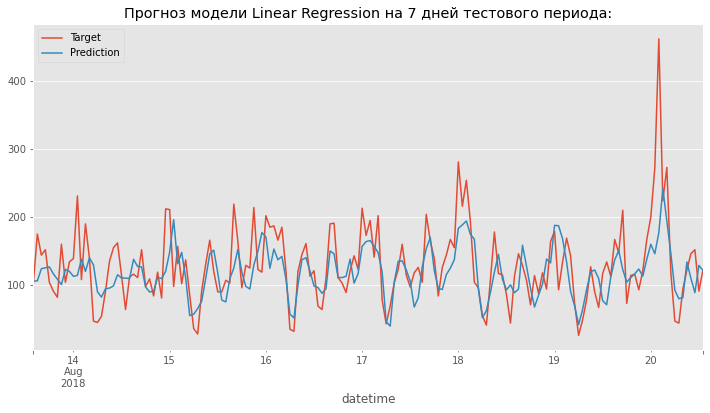

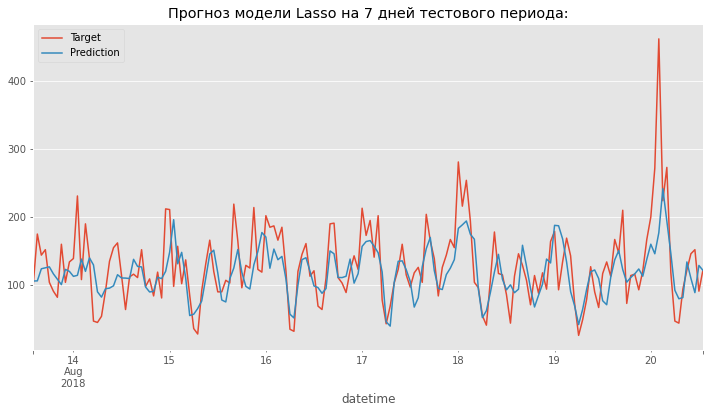

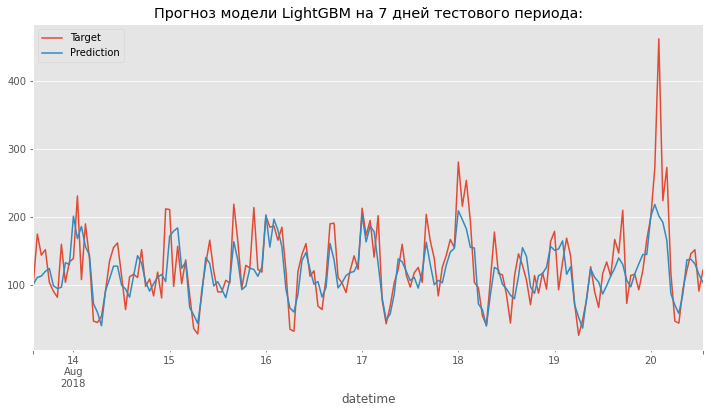

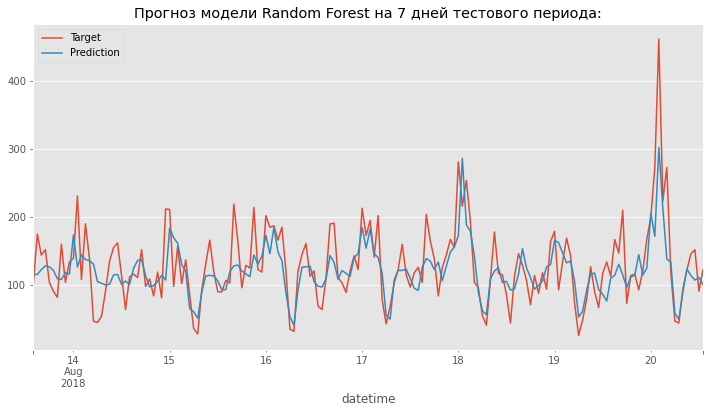

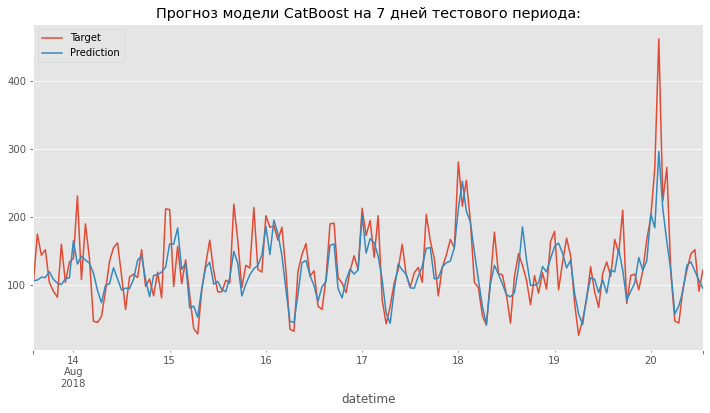

In [23]:
%%time
models = modelling(data, models_dic, mod_pars)

### Итоги

Выведем RMSE на тестовой выборке по итогам обучения моделей:

In [24]:
models = models.sort_values('test_rmse')# 
models.loc[:, ['name', 'test_rmse', 'test_r2']]

,name,test_rmse,test_r2
11,CatBoost,40.406383,0.523731
8,LightGBM,42.793330,0.465800
107,Random Forest,43.358812,0.451588
60,Lasso,46.787084,0.361437
12,Linear Regression,46.788093,0.361409


## Тестирование

Мы получили лучший результат прогноза заказов такси с помощью модели CatBoost. Все результаты выглядят следующим образом:

In [25]:
models_summary = models.loc[:, ['name', 'test_rmse', 'test_r2', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']].reset_index()
models_summary

,index,name,test_rmse,test_r2,mean_test_score,mean_fit_time,mean_score_time,params
0,11,CatBoost,40.406383,0.523731,-27.259830,8.355014,0.041498,"{'compose__max_lag': 30, 'compose__rolling_mea..."
1,8,LightGBM,42.793330,0.465800,-27.743640,0.202975,0.034997,"{'compose__max_lag': 10, 'compose__rolling_mea..."
2,107,Random Forest,43.358812,0.451588,-28.447879,3.292629,0.062491,"{'compose__max_lag': 30, 'compose__rolling_mea..."
3,60,Lasso,46.787084,0.361437,-27.841656,0.071491,0.036496,"{'compose__max_lag': 30, 'compose__rolling_mea..."
4,12,Linear Regression,46.788093,0.361409,-27.840982,0.043496,0.041995,"{'compose__max_lag': 30, 'compose__rolling_mea..."


Как видим, CatBoost дает лучший прогноз, но при этом требует больше времени на обучение. Попробуем снизить RMSE на нашей лучшей модели.

Мы знаем, что в зависимости от глубины временного лага в параметрах ряд первых объектов получает пропуски в новых признаках, которые мы заполняем первым доступным значением. В результате модель обучается на искаженных данных и дает неверный прогноз в начале временного ряда, что хорошо видно по графикам обучения моделей.

Попробуем создать новый датасет с дополнительными признаками, разделить его и заново обучить модель.

In [26]:
taxi = TaxiFeatComposer('num_orders', 30, 6, fillna=False, drop_target=False)
taxi_new = taxi.fit_transform(data).dropna()
X_train, X_test, y_train, y_test = split_data(taxi_new, target='num_orders', drop_target=True)

Выборки для моделирования:
X_train: (3947, 35), y_train: (3947,)
X_test: (439, 35), y_test: (439,)


In [27]:
%%time
# обучим модель
cb_model = CatBoostRegressor(random_seed=SEED, verbose=0)
cb_model.fit(X_train, y_train)

CPU times: total: 34.9 s
Wall time: 11.5 s


RMSE = 40.18     R2 = 0.53
-----------------------------------------------------------------


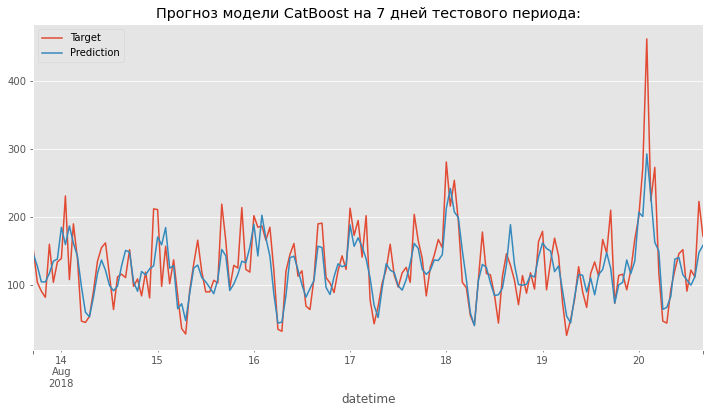

In [28]:
pred = cb_model.predict(X_test)
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)

print(f'RMSE = {rmse:.2f}     R2 = {r2:.2f}')
print('-'*65)

# график предсказания
graf = pd.DataFrame({'Target':y_test, 'Prediction':pred})
_ = graf.head(24*7).plot(figsize=(12, 6), title=f'Прогноз модели CatBoost на 7 дней тестового периода:')

Точность прогноза улучшилась незначительно, но по графику видно, что предсказание стало ближе к факту на всем диапазоне.

## Выводы

В ходе проведенного анализа данных о заказах мы проделали следующие шаги:

1. Ресемплировали данные на часовой интервал
2. Исследовали данные на предмет трендов и наличия сезонности
3. Скомпилировали дополнительные признаки для обучения моделей
4. Провели обучение с перебором параметров по сетке для моделей Linear Regression, Lasso, LightGBM, Random Forest и CatBoost. Победил CatBoost.
5. Свели данные всех моделей сведены в единую таблицу
6. Внесли изменения в обучающие данные с целью улучшения предсказаний модели CatBoost.
7. Достигли значения метрики RMSE на тестовой выборке: ~40

## Extra

Добавим небольшую визуализацию касательно важности признаков с помощью пакета Shap.

In [29]:
import shap
shap.initjs()

In [30]:
explainer = shap.TreeExplainer(cb_model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
print('Динамика контрольной метрики в процессе обучения')
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

Динамика контрольной метрики в процессе обучения


Влияние признаков на процесс обучения модели


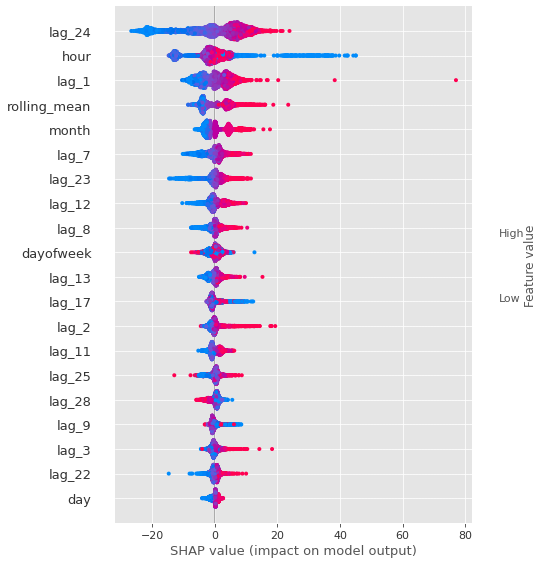

In [31]:
print('Влияние признаков на процесс обучения модели')
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Из графика следует, что наибольшее значение в процессе обучения имели суточные и часовые сдвиги временного ряда, а также скользящее среднее, час и месяц наблюдения. Такие результаты, в целом, соответствуют здравому смыслу и вполне интерпретируемы.